<a href="https://colab.research.google.com/github/binyamin8914/desarrollo-nodo/blob/main/Ev2_Programaci%C3%B3n_Cient%C3%ADfica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install ucimlrepo

Primeras filas:
   year  month  day  hour  DEWP  TEMP    PRES cbwd    Iws  Is  Ir  pm2.5
0  2010      1    1     0   -21 -11.0  1021.0   NW   1.79   0   0    NaN
1  2010      1    1     1   -21 -12.0  1020.0   NW   4.92   0   0    NaN
2  2010      1    1     2   -21 -11.0  1019.0   NW   6.71   0   0    NaN
3  2010      1    1     3   -21 -14.0  1019.0   NW   9.84   0   0    NaN
4  2010      1    1     4   -20 -12.0  1018.0   NW  12.97   0   0    NaN


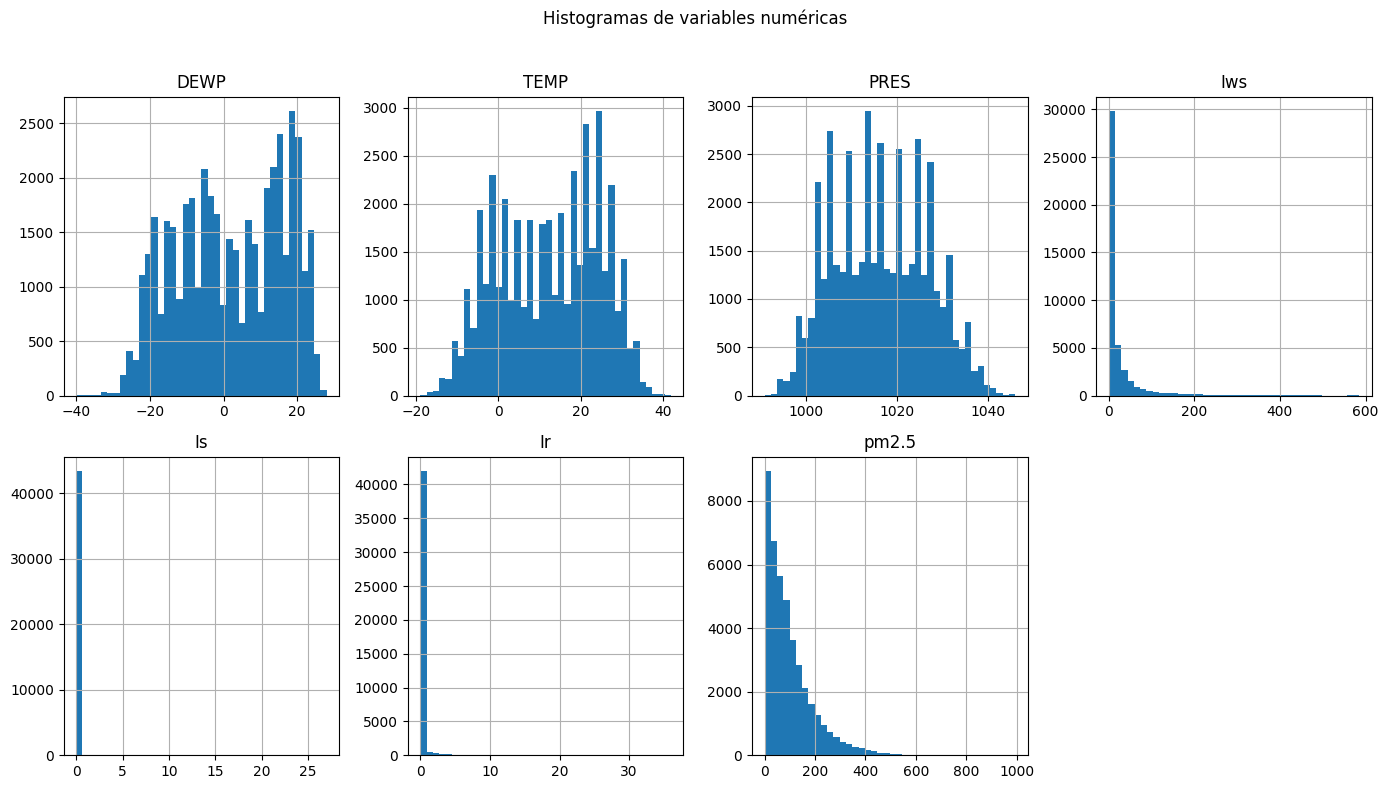

Correlaciones con pm2.5:
 DEWP    0.179360
TEMP   -0.091660
PRES   -0.048429
Iws    -0.265878
Is           NaN
Ir     -0.011860
Name: pm2.5, dtype: float64


In [26]:
# 1. EXPLORACIÓN INICIAL Y LIMPIEZA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor

# Descargar y cargar el dataset
beijing_pm2_5 = fetch_ucirepo(id=381)
X = beijing_pm2_5.data.features
y = beijing_pm2_5.data.targets
df = pd.concat([X, y], axis=1)

# Explora primeros datos y distribuciones
print("Primeras filas:")
print(df.head())
variables_numericas = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']
df[variables_numericas].hist(bins=40, figsize=(14, 8), layout=(2,4))
plt.suptitle("Histogramas de variables numéricas")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Limpieza: quitar filas con NA en variables numéricas
df_clean = df[variables_numericas + ['year', 'month', 'day', 'hour']].dropna().copy()

# Limpieza de outliers (percentil 1 y 99)
for col in variables_numericas:
    q_low = df_clean[col].quantile(0.01)
    q_high = df_clean[col].quantile(0.99)
    df_clean = df_clean[(df_clean[col] >= q_low) & (df_clean[col] <= q_high)]

# Correlación con pm2.5
corrs = df_clean[variables_numericas].corr()['pm2.5'].drop('pm2.5')
print("Correlaciones con pm2.5:\n", corrs)

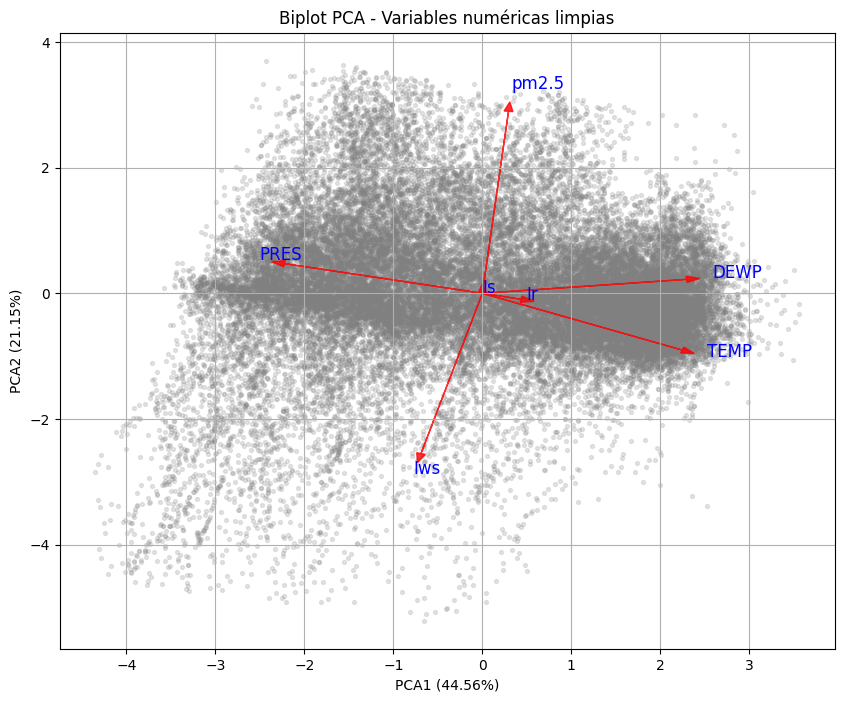

Varianza explicada por cada componente: [0.44560387 0.21148704]
Varianza total explicada (2 componentes): 0.6570909110057817


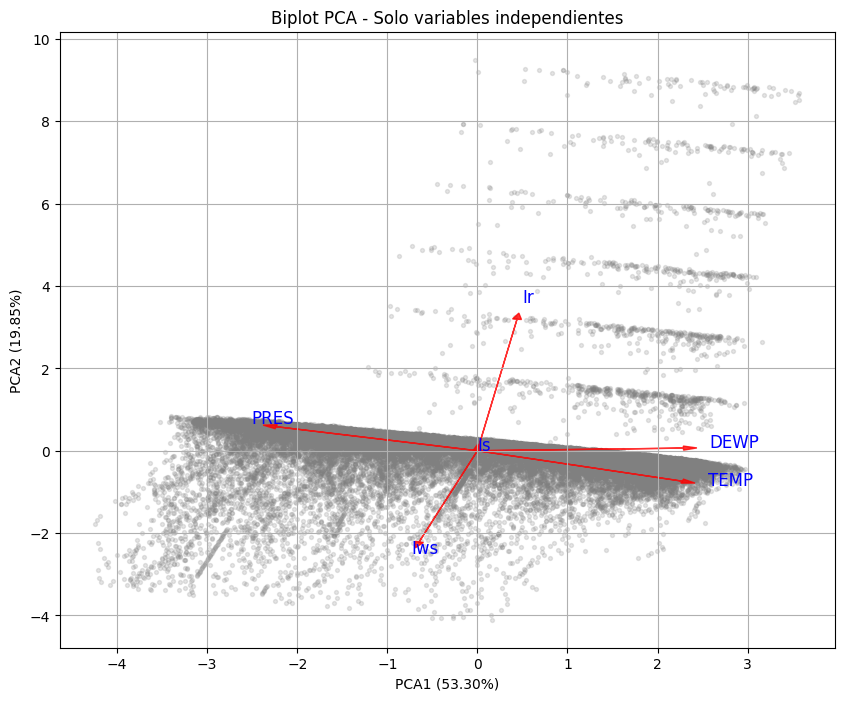

Varianza total explicada (2 componentes, independientes): 0.7314415486333503


In [27]:
# 2. ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)
# 2.1 PCA con todas las variables (limpias)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[variables_numericas])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.2, s=8, color='grey')
for i, var in enumerate(variables_numericas):
    plt.arrow(0, 0, pca.components_[0, i]*4, pca.components_[1, i]*4, color='r', alpha=0.8, head_width=0.1)
    plt.text(pca.components_[0, i]*4.5, pca.components_[1, i]*4.5, var, color='b', fontsize=12)
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("Biplot PCA - Variables numéricas limpias")
plt.grid()
plt.show()
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza total explicada (2 componentes):", np.sum(pca.explained_variance_ratio_))

# 2.2 PCA solo variables independientes
variables_indep = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
X_scaled_indep = scaler.fit_transform(df_clean[variables_indep])
pca_indep = PCA(n_components=2)
X_pca_indep = pca_indep.fit_transform(X_scaled_indep)
plt.figure(figsize=(10,8))
plt.scatter(X_pca_indep[:,0], X_pca_indep[:,1], alpha=0.2, s=8, color='grey')
for i, var in enumerate(variables_indep):
    plt.arrow(0, 0, pca_indep.components_[0, i]*4, pca_indep.components_[1, i]*4, color='r', alpha=0.8, head_width=0.1)
    plt.text(pca_indep.components_[0, i]*4.5, pca_indep.components_[1, i]*4.5, var, color='b', fontsize=12)
plt.xlabel(f"PCA1 ({pca_indep.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PCA2 ({pca_indep.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("Biplot PCA - Solo variables independientes")
plt.grid()
plt.show()
print("Varianza total explicada (2 componentes, independientes):", np.sum(pca_indep.explained_variance_ratio_))

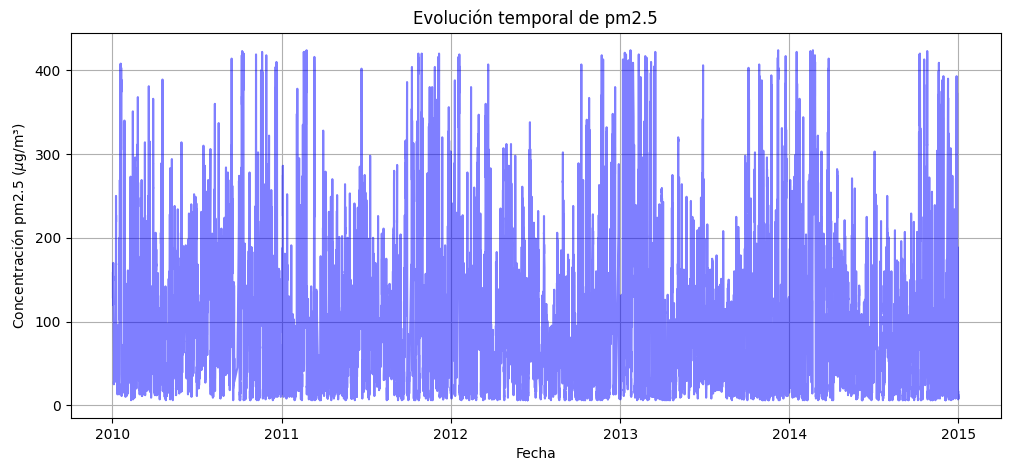

In [32]:
# 3. EVOLUCIÓN TEMPORAL DE PM2.5
df_clean['datetime'] = pd.to_datetime(df_clean[['year', 'month', 'day', 'hour']])
df_clean = df_clean.sort_values('datetime').reset_index(drop=True)
plt.figure(figsize=(12,5))
plt.plot(df_clean['datetime'], df_clean['pm2.5'], color='blue', alpha=0.5)
plt.xlabel('Fecha')
plt.ylabel('Concentración pm2.5 ($\mu$g/m³)')
plt.title('Evolución temporal de pm2.5')
plt.grid(True)
plt.show()


R² Regresión Lineal Multivariable: 0.23920927398571434


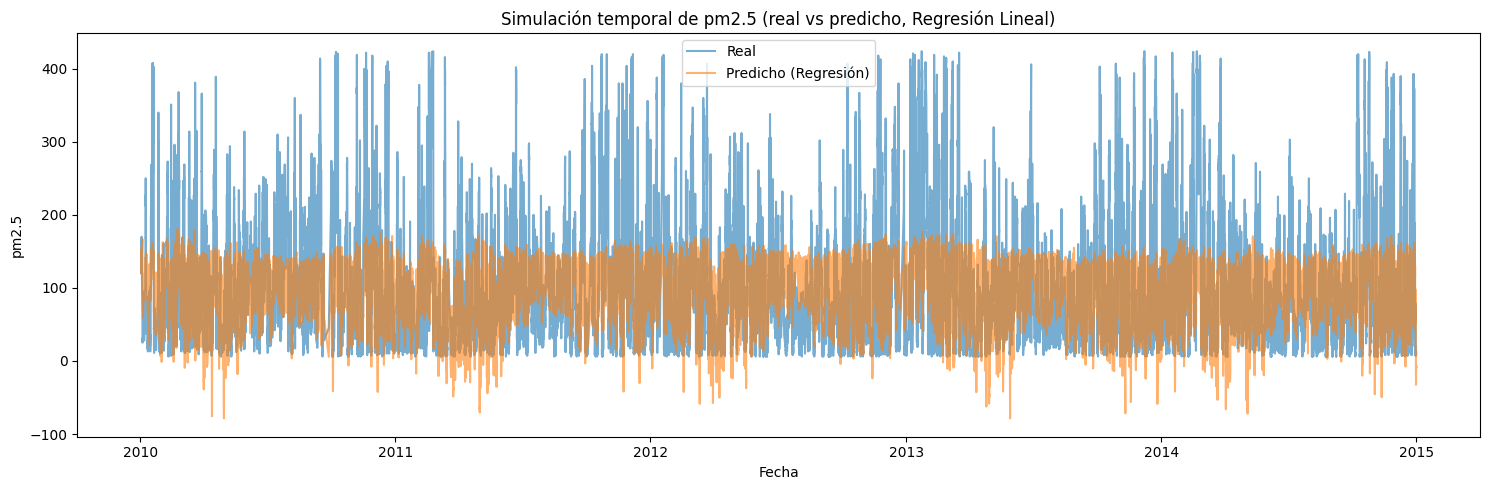

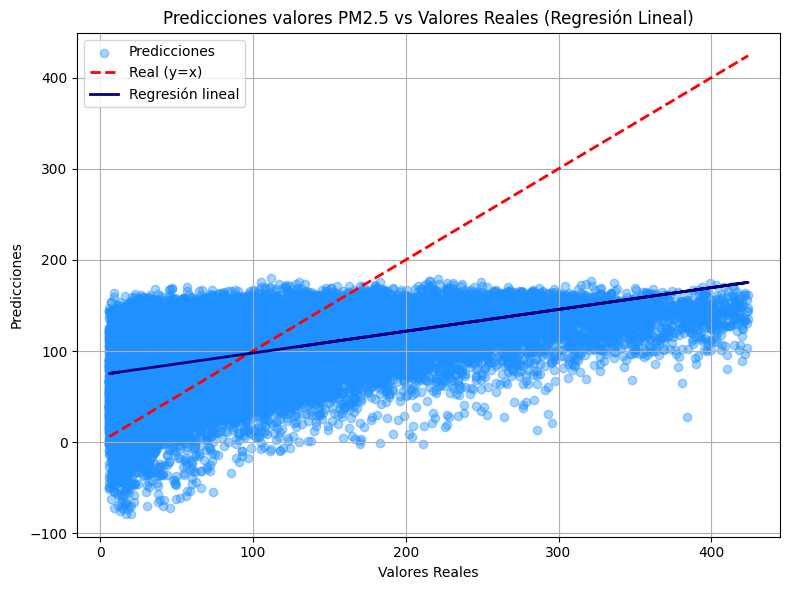

In [34]:
# 4. MODELADO PREDICTIVO Y VISUALIZACIÓN DE RESULTADOS

# 4.1 Regresión lineal multivariable (MÉTODO BASE)
X = df_clean[variables_indep]
y = df_clean['pm2.5']
modelo_lr = LinearRegression()
modelo_lr.fit(X, y)
y_pred_lr = modelo_lr.predict(X)
print("R² Regresión Lineal Multivariable:", r2_score(y, y_pred_lr))
plt.figure(figsize=(15,5))
plt.plot(df_clean['datetime'], y, label='Real', alpha=0.6)
plt.plot(df_clean['datetime'], y_pred_lr, label='Predicho (Regresión)', alpha=0.6)
plt.xlabel('Fecha')
plt.ylabel('pm2.5')
plt.title('Simulación temporal de pm2.5 (real vs predicho, Regresión Lineal)')
plt.legend()
plt.tight_layout()
plt.show()

# Scatter plot real vs predicho
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred_lr, color='dodgerblue', alpha=0.4, label="Predicciones")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label="Real (y=x)")
m, b = np.polyfit(y, y_pred_lr, 1)
plt.plot(y, m*y+b, color='navy', lw=2, label='Regresión lineal')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones valores PM2.5 vs Valores Reales (Regresión Lineal)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

R² Random Forest: 0.8753416522038582


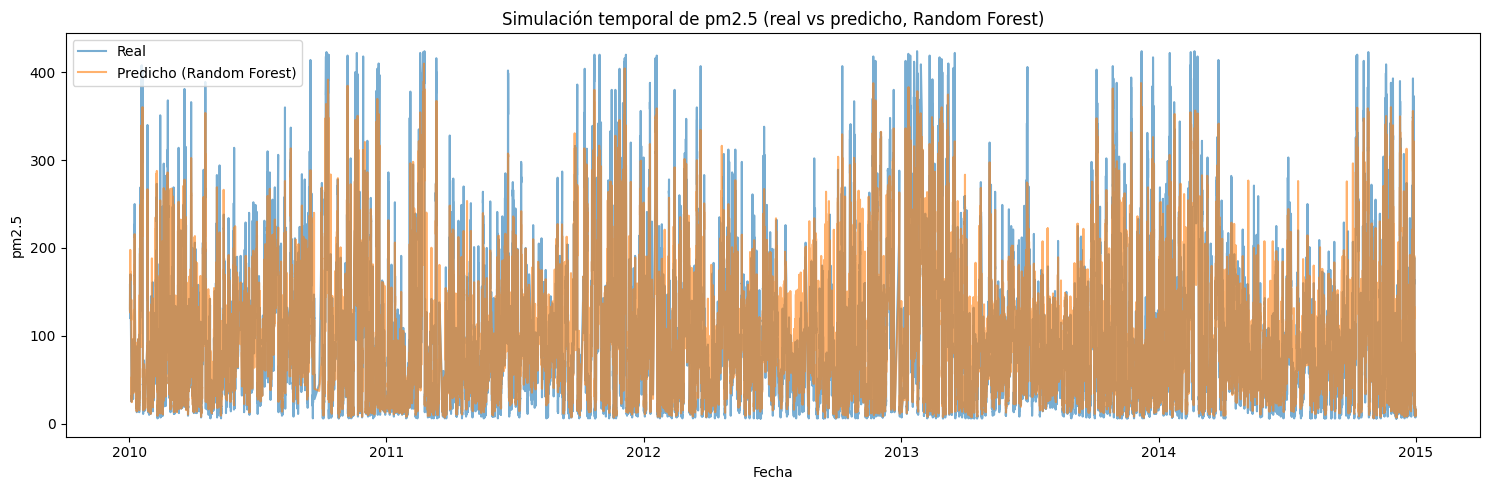

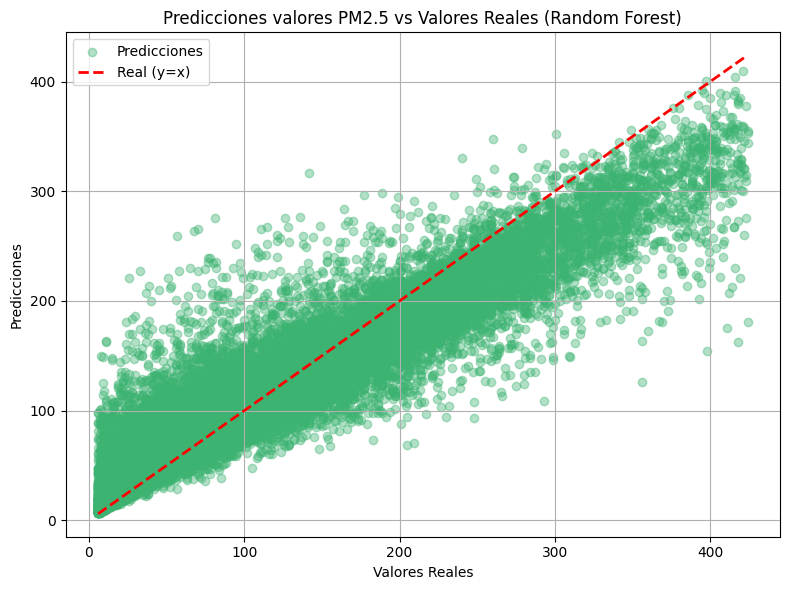

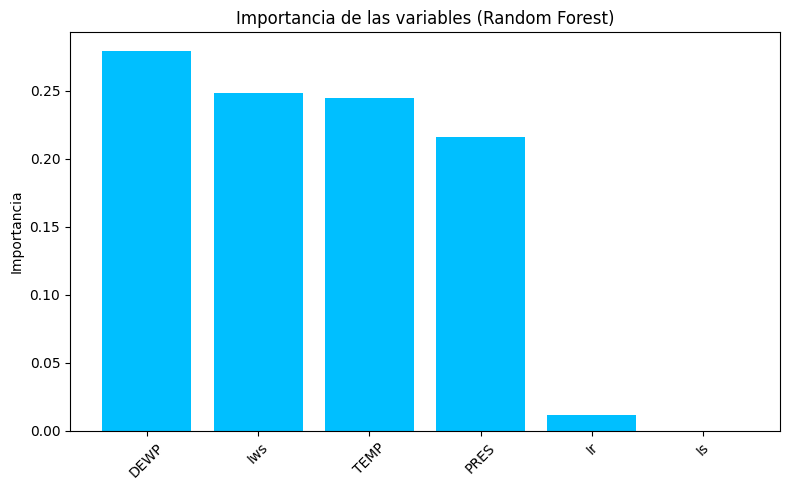

In [35]:
# 4.2 Random Forest (MODELO MEJORADO)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
y_pred_rf = rf.predict(X)
print("R² Random Forest:", r2_score(y, y_pred_rf))
plt.figure(figsize=(15,5))
plt.plot(df_clean['datetime'], y, label='Real', alpha=0.6)
plt.plot(df_clean['datetime'], y_pred_rf, label='Predicho (Random Forest)', alpha=0.6)
plt.xlabel('Fecha')
plt.ylabel('pm2.5')
plt.title('Simulación temporal de pm2.5 (real vs predicho, Random Forest)')
plt.legend()
plt.tight_layout()
plt.show()

# Scatter plot real vs predicho (Random Forest)
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred_rf, color='mediumseagreen', alpha=0.4, label="Predicciones")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label="Real (y=x)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones valores PM2.5 vs Valores Reales (Random Forest)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Importancia de variables
importancias = rf.feature_importances_
indices = np.argsort(importancias)[::-1]
plt.figure(figsize=(8,5))
plt.bar(range(len(variables_indep)), importancias[indices], color='deepskyblue')
plt.xticks(range(len(variables_indep)), [variables_indep[i] for i in indices], rotation=45)
plt.ylabel("Importancia")
plt.title("Importancia de las variables (Random Forest)")
plt.tight_layout()
plt.show()

R² (Optimización ARX, scipy): 0.9257684754972835


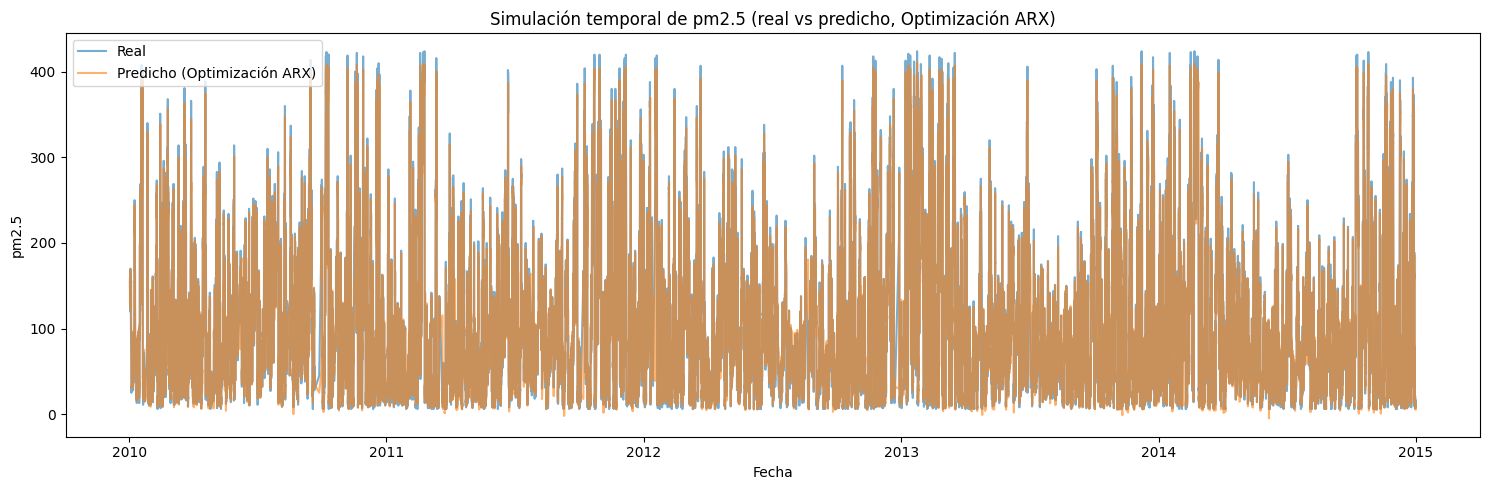

In [41]:
# 5. OPTIMIZACIÓN DEL MODELO ARX (REGRESIÓN CON MEMORIA TEMPORAL) CON SCIPY.MINIMIZE

# 1. Crear columna rezagada (lag 1) en el DataFrame limpio
df_arx = df_clean.copy()
df_arx['pm2.5_prev'] = df_arx['pm2.5'].shift(1)
df_arx = df_arx.dropna()

# 2. Definir variables predictoras y target para ARX
feature_cols_arx = ['pm2.5_prev', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
X_arx = df_arx[feature_cols_arx].values
y_arx = df_arx['pm2.5'].values

# 3. Definir la función objetivo (MSE)
def funcion_objetivo(params, X, y):
    intercept = params[0]
    coefs = params[1:]
    pred = intercept + np.dot(X, coefs)
    mse = np.mean((y - pred) ** 2)
    return mse

# 4. Inicialización de parámetros
params_inicial = np.zeros(X_arx.shape[1] + 1)

# 5. Optimización con scipy.optimize
res = minimize(funcion_objetivo, params_inicial, args=(X_arx, y_arx))
params_optimos = res.x
intercept_opt = params_optimos[0]
coefs_opt = params_optimos[1:]

# 6. Predicción y evaluación
pm25_pred_opt = intercept_opt + np.dot(X_arx, coefs_opt)
r2_opt = r2_score(y_arx, pm25_pred_opt)
print("R² (Optimización ARX, scipy):", r2_opt)

# 7. Gráfica de resultados
plt.figure(figsize=(15,5))
plt.plot(df_arx['datetime'], y_arx, label='Real', alpha=0.6)
plt.plot(df_arx['datetime'], pm25_pred_opt, label='Predicho (Optimización ARX)', alpha=0.6)
plt.xlabel('Fecha')
plt.ylabel('pm2.5')
plt.title('Simulación temporal de pm2.5 (real vs predicho, Optimización ARX)')
plt.legend()
plt.tight_layout()
plt.show()
